### Load libraries

In [ ]:
# Install detectron2:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0) # After installation restart Colab's runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3z0ttptl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3z0ttptl
  Resolved https://github.com/facebookresearch/detectron2.git to commit 94113be6e12db36b8c7601e13747587f19ec92fe
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filena

In [ ]:
!pip install geopandas
!pip install ipyleaflet
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.7 MB/s eta 0:00:00


In [ ]:
import yaml
import torch, torchvision

# Detectron2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


In [52]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
import os
import datetime
import folium
import ipywidgets
import plotly.express as px
from folium import plugins, FeatureGroup
from folium.plugins import HeatMap, TimeSliderChoropleth
from shapely.geometry import Polygon
from branca.colormap import linear
from datetime import datetime, timedelta
import plotly.graph_objs as go
from sklearn import preprocessing
import rasterio
import cv2
from osgeo import osr, gdal

In [ ]:
# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Show data transformation example

## Model data

In [ ]:
# Model path
model_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/ModelOutput/faster_rcnn_R_101_FPN_3x_26000iter/model_final.pth'


In [ ]:
# detectron2 configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))  # path to the YAML configuration file for a specific pre-trained model
cfg.DATASETS.TRAIN = ()
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has class ship
cfg.OUTPUT_DIR = "output/"
cfg.MODEL.WEIGHTS = os.path.join(model_path) # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # following Zhang et al. 2020
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # following Zhang et al. 2020
cfg.MODEL.DEVICE='cpu'

predictor = DefaultPredictor(cfg)

[06/19 02:43:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/output/ModelOutput/faster_rcnn_R_101_FPN_3x_26000iter/model_final.pth ...


## Data transformation

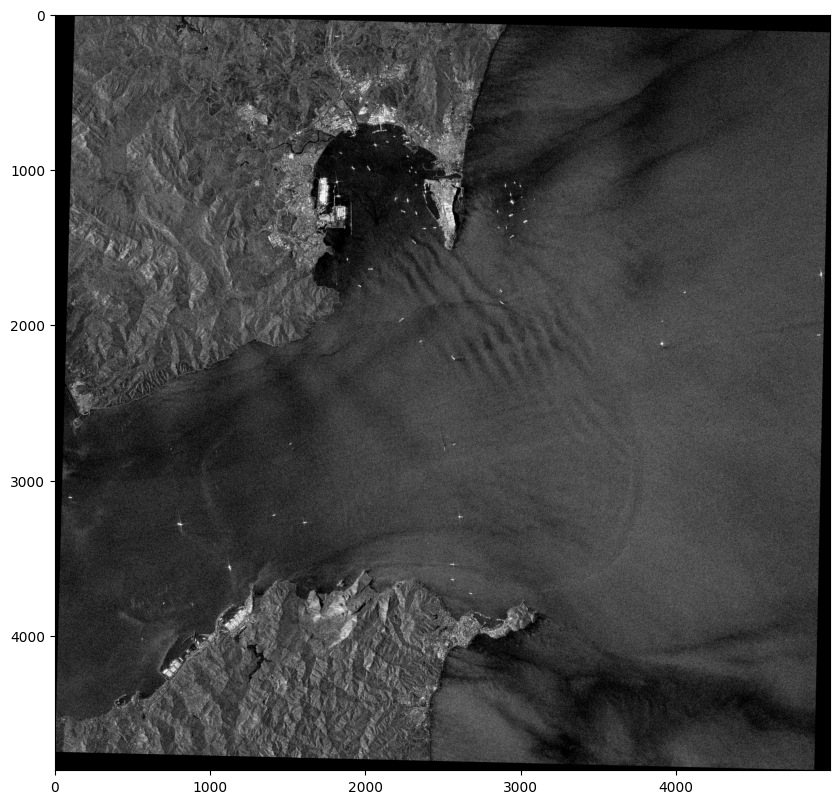

In [53]:
# Read the TIFF image with rasterio
with rasterio.open('/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/sentinel_images/sentinel_test_image.tif') as src:
    img = src.read()
    # Set the new minimum and maximum values
    new_min = -20
    new_max = 10

    # Clip the pixel values to the new range
    img_clipped = np.clip(img, new_min, new_max).astype(src.profile['dtype'])

# Transpose the image to BGR format
img_bgr = img_clipped.transpose(1, 2, 0)[:, :, ::-1]

# Rescale the image to 0-255 range
img_bgr = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)



# # Save the image as a JPEG file
cv2.imwrite('/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/sentinel_images/raw_test_image.jpg', img_bgr)

plt.figure(figsize=(10, 10))
plt.imshow(img_bgr,cmap='gray')
plt.show()

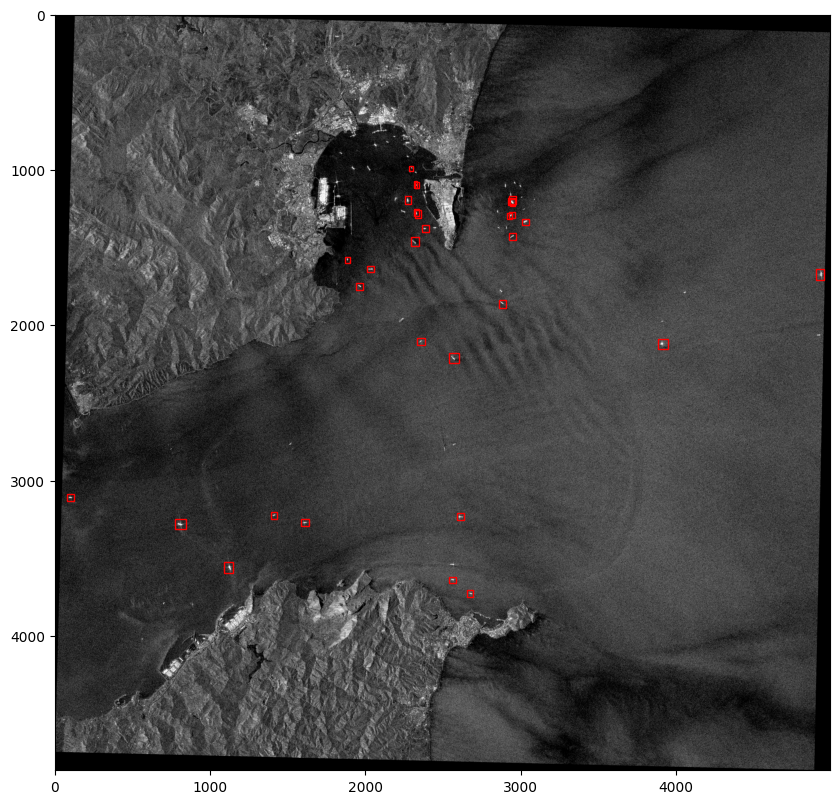

In [54]:
# Read the TIFF image with rasterio
with rasterio.open('/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/sentinel_images/sentinel_test_image.tif') as src:
    img = src.read()
    # Set the new minimum and maximum values
    new_min = -20
    new_max = 10
    # Clip the pixel values to the new range
    img_clipped = np.clip(img, new_min, new_max).astype(src.profile['dtype'])

# Transpose the image dimensions to BGR format (1, 4867, 4992) to (4867, 4992)
img_bgr = img_clipped.transpose(1, 2, 0)[:, :, ::-1]

# Rescale the image to 0-255 range and transform dtype from float64 to uint8
img_bgr = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Convert the image from grayscale to BGR format (4867, 4992, 3)
img_bgr_new = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)

# Make predictions on the image
outputs = predictor(img_bgr_new)

# Get the bounding boxes for the predicted objects
boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()
classes = outputs['instances'].pred_classes.cpu().numpy()
scores = outputs['instances'].scores.cpu().numpy()

# Draw the bounding boxes on the image
plt.figure(figsize=(10, 10))

for box in boxes:
    x1, y1, x2, y2 = box
    plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=1).set_clip_on(False)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=1))

# Show the image with the predicted bounding boxes
plt.imshow(img_bgr_new,cmap='gray')
plt.show()

In [55]:
# Draw the bounding boxes on the image
for box in boxes:
    x1, y1, x2, y2 = [int(coordinate) for coordinate in box]  # ensure the coordinates are integers
    cv2.rectangle(img_bgr_new, (x1, y1), (x2, y2), (0, 0, 255), 3)  # BGR color format

# Save the image with the predicted bounding boxes
cv2.imwrite("/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/sentinel_images/bounded_test_image.jpg", img_bgr_new)


True

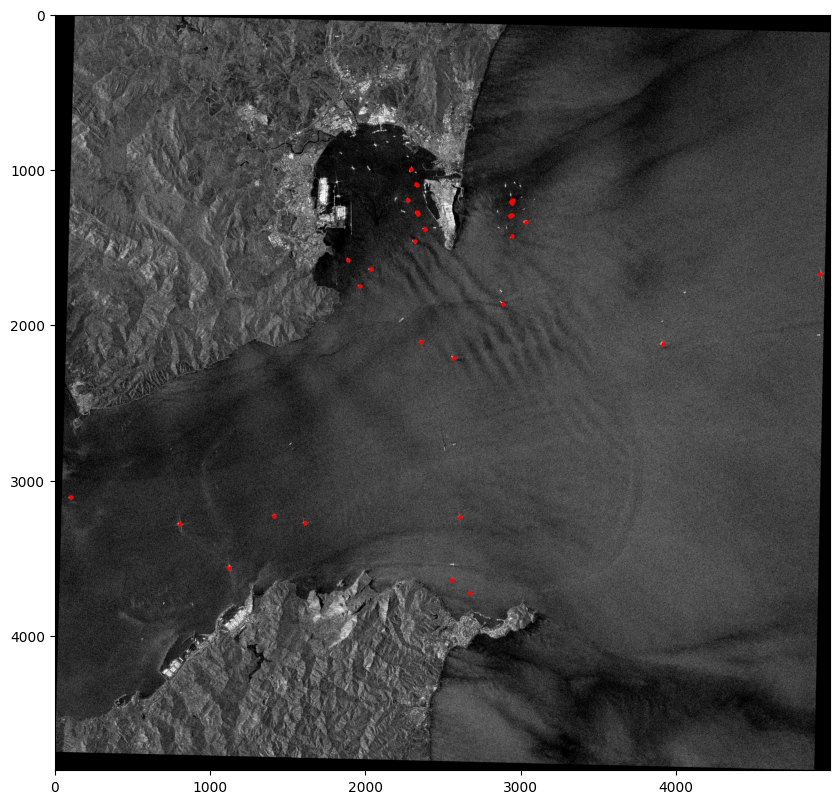

In [74]:
# Read the TIFF image with rasterio
with rasterio.open('/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/sentinel_images/sentinel_test_image.tif') as src:
    img = src.read()
    # Set the new minimum and maximum values
    new_min = -20
    new_max = 10
    # Clip the pixel values to the new range
    img_clipped = np.clip(img, new_min, new_max).astype(src.profile['dtype'])

# Transpose the image dimensions to BGR format (1, 4867, 4992) to (4867, 4992)
img_bgr = img_clipped.transpose(1, 2, 0)[:, :, ::-1]

# Rescale the image to 0-255 range and transform dtype from float64 to uint8
img_bgr = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Convert the image from grayscale to BGR format (4867, 4992, 3)
img_bgr_new = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)

# Represent points
plt.figure(figsize=(10, 10))

centroids = np.column_stack(((boxes[:,0]+boxes[:,2])/2,
                             (boxes[:,1]+boxes[:,3])/2))

plt.imshow(img_bgr_new, cmap='gray')
plt.scatter(centroids[:,0], centroids[:,1], s=5, c='red')

plt.show()


In [77]:
# Represent points
centroids = np.column_stack(((boxes[:,0]+boxes[:,2])/2,
                             (boxes[:,1]+boxes[:,3])/2))

# Draw circles on the centroids
for centroid in centroids:
    x, y = [int(coordinate) for coordinate in centroid]  # ensure the coordinates are integers
    cv2.circle(img_bgr_new, (x, y), radius=15, color=(0, 0, 255), thickness=-1)  # BGR color format

# Save the image with the predicted centroids
cv2.imwrite("/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/sentinel_images/centroids_test_image.jpg", img_bgr_new)


True

# Combine all shp files

Before running the final analysis combine all extracted shapefiles into one single file. (RUN ONLY ONCE)

In [ ]:
# RUN ONLY ONCE
# Specify the directory containing the shapefiles
shapefile_dir = ''

# List to store all shapefile paths
shapefile_paths = []

# Function to recursively search for shapefiles in the directory and its subdirectories
def find_shapefiles(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.shp'):
                shapefile_paths.append(os.path.join(root, file))

# Call the function to populate the shapefile_paths list
find_shapefiles(shapefile_dir)

# Read all shapefiles and combine them into a single GeoDataFrame
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(shapefile) for shapefile in shapefile_paths], ignore_index=True))

# Specify the output shapefile path
output_shapefile = ''

# Save the combined shapefile
gdf.to_file(output_shapefile, driver='ESRI Shapefile')


# Case study

# Read data

In [ ]:
# Read the shapefile
coastline_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/shapefiles/corcovado_coastline/corcovado_coastline.shp'
vessels_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/shapefiles/baseM/combined_baseM/combined_baseM.shp'
aoi_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/regions_of_interest/corcovadogulf.geojson'
coastline = gpd.read_file(coastline_path)
vessels = gpd.read_file(vessels_path)
aoi = gpd.read_file(aoi_path)

# Set the CRS
coastline.crs = 'EPSG:4326'
vessels.crs = 'EPSG:4326'
aoi.crs = 'EPSG:4326'

# Filter data

Select vessels with scores higher than 0.6 and apply coastline buffer.

Filter ouy those detections with a score lower than 0.6.

In [ ]:
# Convert 'date' column to datetime type
vessels['date'] = pd.to_datetime(vessels['date'])
# Extract the year and add it as a new column
vessels['year'] = vessels['date'].dt.year

# Filter by score value
filtered_vessels = vessels[vessels['score'] > 0.6]

In [ ]:
# Create a Folium map centered on the centroid of the vessels GeoDataFrame
center_lat = aoi.centroid.y.mean()
center_lon = aoi.centroid.x.mean()
map = folium.Map(location=[center_lat, center_lon], zoom_start=10,tiles=None)

# Add ESRI Ocean Base map
esri_ocean = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Ocean',
    overlay=False,
    control=True
)
esri_ocean.add_to(map)

# Create the coastline feature group
coastline_feature_group = folium.FeatureGroup(name='Coastline')

# Style function for coastline
def coastline_style(feature):
    return {'fillColor': '#808080', 'color': '#FFFFFF', 'weight': 0.5}

# Iterate over the rows of the GeoDataFrame representing the coastline and add the polygon to the map
for index, row in coastline.iterrows():
    folium.GeoJson(row['geometry'], style_function=coastline_style).add_to(coastline_feature_group)

# Add the coastline feature group to the map
map.add_child(coastline_feature_group)

# Style function for AOI
def aoi_style(feature):
    return {'fillOpacity': 0, 'color': '#000000', 'weight': 0.5, 'dashArray': '5, 5'}

# Add AOI polygons
aoi_feature_group = folium.FeatureGroup(name='Area of Interest')
for index, row in aoi.iterrows():
    folium.GeoJson(row['geometry'], style_function=aoi_style).add_to(aoi_feature_group)
map.add_child(aoi_feature_group)

# Sort the unique years
unique_years = np.sort(filtered_vessels['year'].unique())

# Create a colormap for the different years
colors = cm.Reds(np.linspace(0.5, 1, len(unique_years)))

# Create a feature group for each year
for year, color in zip(unique_years, colors):
    year_vessels = filtered_vessels[filtered_vessels['year'] == year]
    year_feature_group = folium.FeatureGroup(name=str(year))

    # Convert RGB color to hex
    color = cm.colors.rgb2hex(color)

    # Iterate over the rows of the GeoDataFrame and add markers for each point
    for index, row in year_vessels.iterrows():
        lat, lon = row['geometry'].y, row['geometry'].x
        folium.CircleMarker(location=[lat, lon], radius=2, color='transparent', fill=True, fill_color=color, fill_opacity=0.6,
                            popup=f"Year: {year}").add_to(year_feature_group)

    # Add the year feature group to the map
    map.add_child(year_feature_group)

# Add layer control to the map (this will add the layer selection control to the map)
map.add_child(folium.LayerControl())

# Display the map
map


Output hidden; open in https://colab.research.google.com to view.

Filter those vessels detections close to the coast.

In [ ]:
# Apply buffer to geometries
buffer_distance = 0.02  # Buffer distance in (degrees) the unit of the shapefile's coordinate reference system
buffered_coastline = coastline.buffer(buffer_distance)
buffered_coastline = gpd.GeoDataFrame(geometry=buffered_coastline)
# Clip the buffered coastline using the aoi
clipped_coastline = gpd.overlay(buffered_coastline, aoi, how='intersection')


# Perform the spatial operation to select non-intersecting points
non_intersecting_vessels = filtered_vessels[~filtered_vessels.intersects(buffered_coastline.geometry.iloc[0])]

<ipython-input-7-40412746d359>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_coastline = coastline.buffer(buffer_distance)


In [ ]:
# Create a Folium map centered on the centroid of the vessels GeoDataFrame
center_lat = aoi.centroid.y.mean()
center_lon = aoi.centroid.x.mean()
map = folium.Map(location=[center_lat, center_lon], zoom_start=10,tiles=None)

# Add ESRI Ocean Base map
esri_ocean = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Ocean',
    overlay=False,
    control=True
)
esri_ocean.add_to(map)

# Create the coastline feature group
coastline_feature_group = folium.FeatureGroup(name='Coastline')

# Style function for coastline
def coastline_style(feature):
    return {'fillColor': '#808080', 'color': '#FFFFFF', 'weight': 0.5}

# Iterate over the rows of the GeoDataFrame representing the coastline and add the polygon to the map
for index, row in coastline.iterrows():
    folium.GeoJson(row['geometry'], style_function=coastline_style).add_to(coastline_feature_group)

# Add the coastline feature group to the map
map.add_child(coastline_feature_group)

## Add buffer zone
buffer_feature_group = folium.FeatureGroup(name='Buffer')

def buffer_style(feature):
    return {'fillColor': '#808080', 'color': '#FFFFFF', 'weight': 0.5}

for index, row in clipped_coastline.iterrows():
    folium.GeoJson(row['geometry'], style_function=buffer_style).add_to(buffer_feature_group)

map.add_child(buffer_feature_group)

# Style function for AOI
def aoi_style(feature):
    return {'fillOpacity': 0, 'color': '#000000', 'weight': 0.5, 'dashArray': '5, 5'}

# Add AOI polygons
aoi_feature_group = folium.FeatureGroup(name='Area of Interest')
for index, row in aoi.iterrows():
    folium.GeoJson(row['geometry'], style_function=aoi_style).add_to(aoi_feature_group)
map.add_child(aoi_feature_group)

## Sort the unique years
unique_years = np.sort(non_intersecting_vessels['year'].unique())

# Create a colormap for the different years
colors = cm.Reds(np.linspace(0.5, 1, len(unique_years)))

# Create a feature group for each year
for year, color in zip(unique_years, colors):
    year_vessels = non_intersecting_vessels[non_intersecting_vessels['year'] == year]
    year_feature_group = folium.FeatureGroup(name=str(year))

    # Convert RGB color to hex
    color = cm.colors.rgb2hex(color)

    # Iterate over the rows of the GeoDataFrame and add markers for each point
    for index, row in year_vessels.iterrows():
        lat, lon = row['geometry'].y, row['geometry'].x
        folium.CircleMarker(location=[lat, lon], radius=2, color='transparent', fill=True, fill_color=color, fill_opacity=0.6,
                            popup=f"Year: {year}").add_to(year_feature_group)

    # Add the year feature group to the map
    map.add_child(year_feature_group)

# Add layer control to the map (this will add the layer selection control to the map)
map.add_child(folium.LayerControl())

# Display the map
map


<ipython-input-8-248910b7be7b>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = aoi.centroid.y.mean()
<ipython-input-8-248910b7be7b>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = aoi.centroid.x.mean()


In [ ]:
# Extract the 'year' column as a pandas Series
year_series = non_intersecting_vessels['year']

# Count the number of rows for each unique year value
year_counts = year_series.value_counts().reset_index()

# Rename the columns in the counts DataFrame
year_counts.columns = ['year', 'count']

# Calculate the total count
total_count = year_counts['count'].sum()

# Create a total row
total_row = pd.DataFrame({'year': ['Total'], 'count': [total_count]})

# Append the total row to the counts DataFrame
year_counts = year_counts.append(total_row, ignore_index=True)
# year_counts = pd.concat([year_counts, total_row], ignore_index=True) # Alternative since the other one will be soon deprecated

# Print the resulting DataFrame
print(year_counts)


    year  count
0   2018    103
1   2019     82
2   2022     66
3   2020     59
4   2021     55
5  Total    365


<ipython-input-11-b4713832f0a7>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  year_counts = year_counts.append(total_row, ignore_index=True)


# Density maps

## Heatmap

In [ ]:
# Create a Folium map centered on the centroid of the vessels GeoDataFrame
center_lat = aoi.centroid.y
center_lon = aoi.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Create a new DataFrame with only latitude and longitude columns
df_vessels = pd.DataFrame({
    'Latitude': non_intersecting_vessels.geometry.y,
    'Longitude': non_intersecting_vessels.geometry.x,
    'Date': non_intersecting_vessels['date']
})

# Ensure you're handing it floats
df_vessels['Latitude'] = df_vessels['Latitude'].astype(float)
df_vessels['Longitude'] = df_vessels['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
df_vessels = df_vessels[['Latitude', 'Longitude']]
df_vessels = df_vessels.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
df_vessels = [[row['Latitude'],row['Longitude']] for index, row in df_vessels.iterrows()]

# Plot it on the map
HeatMap(df_vessels, radius =15).add_to(m)


tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)


# Display the map
m

<ipython-input-24-54787d691913>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = aoi.centroid.y
<ipython-input-24-54787d691913>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = aoi.centroid.x


## Heatmap with time

In [ ]:
# Create a new DataFrame with only latitude and longitude columns
df_vessels_t = pd.DataFrame({
    'Latitude': non_intersecting_vessels.geometry.y,
    'Longitude': non_intersecting_vessels.geometry.x,
    'Date': non_intersecting_vessels['date']
})

df_vessels_t['year'] = pd.DatetimeIndex(df_vessels_t['Date']).year

In [ ]:
index_list = df_vessels_t['year'].astype(str)
index_list = index_list.unique().tolist()

In [ ]:
weight_list = []

df_vessels_t['count'] = 1

for x in df_vessels_t['year'].sort_values().unique():
  weight_list.append(df_vessels_t.loc[df_vessels_t['year'] == x,
                                      ['Latitude', 'Longitude','count']].groupby(['Latitude', 'Longitude'])
                                      .sum().reset_index().values.tolist())

In [ ]:
from folium.plugins.heat_map_withtime import HeatMapWithTime
# Create a Folium map centered on the centroid of the vessels GeoDataFrame
center_lat = aoi.centroid.y
center_lon = aoi.centroid.x
m = folium.Map(location=[center_lat, center_lon], control_scale=True, zoom_start=9)

HeatMapWithTime(weight_list, radius =30, index= index_list,
                gradient={0.1: 'blue',0.25:"green",0.5:'yellow',0.75:'orange',1:'red'},
                auto_play=True, min_opacity=0.1, max_opacity=0.8,blur=1,
                use_local_extrema =True, position = "topright").add_to(m)


tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

m

<ipython-input-17-39a305af9ea8>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = aoi.centroid.y
<ipython-input-17-39a305af9ea8>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = aoi.centroid.x


# Density grid

Transform the data to get values per cell

In [ ]:
# Read the GeoJSON file containing your point data
points = non_intersecting_vessels

# Define the grid cell size
cell_size = 0.05  # Adjust this value according to your requirements

# Determine the extent of the point data
xmin, ymin, xmax, ymax = aoi.total_bounds

# Create a list to store grid cells
grid_cells = []

# Generate the grid cells
x_left = xmin
while x_left < xmax:
    x_right = x_left + cell_size
    y_bottom = ymin
    while y_bottom < ymax:
        y_top = y_bottom + cell_size
        polygon = Polygon([(x_left, y_bottom), (x_right, y_bottom),
                           (x_right, y_top), (x_left, y_top)])
        grid_cells.append(polygon)
        y_bottom += cell_size
    x_left += cell_size

# Create a GeoDataFrame for the grid cells
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')

# Perform the spatial join
join = gpd.sjoin(grid, points, op='contains')

# Count the number of points in each cell
point_counts = join.groupby(join.index).size()

# Add the point counts to the grid
grid['point_counts'] = point_counts
grid['id'] = grid.index

# Filter out grid cells with NaN values
filtered_grid = grid.dropna(subset=['point_counts'])

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
# Sum all the values in the 'point_counts' column
total_sum = filtered_grid['point_counts'].sum()

# Print the resulting sum
print(total_sum)

365.0


In [ ]:
# Create a Folium map centered on the centroid of the vessels GeoDataFrame
center_lat = aoi.centroid.y
center_lon = aoi.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)


# Create a Folium Choropleth layer based on the 'point_counts' column
folium.Choropleth(
    filtered_grid,
    name='Grid with Counts',
    data=filtered_grid,
    columns=['id', 'point_counts'],
    key_on='feature.id',
    fill_color='YlGnBu',
    fill_opacity=0.6,
    line_opacity=0,
    nan_fill_opacity=0,  # Set opacity to 0 for cells with point_counts equal to 0
    legend_name='Vessel Counts',
    highlight=True

).add_to(m)



# Add the grid cells as a GeoJson layer to the map
folium.GeoJson(filtered_grid,
               name='Grid with Counts',
               style_function=lambda feature: {
                   'fillColor': 'transparent',
                   'color': 'transparent',
               },
               highlight_function=lambda feature: {
                   'fillColor': 'white',
                   'color': 'black',
                   'weight': 0.5,
                   'fillOpacity': 0.3,
                   'Opacity': 0.3
               },
               tooltip=folium.features.GeoJsonTooltip(fields=['point_counts'],
                                                      aliases=['Vessel Counts'],
                                                      labels=True,
                                                      sticky=True)
               ).add_to(m)



tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)


# Display the map

m

<ipython-input-27-71be431627bc>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = aoi.centroid.y
<ipython-input-27-71be431627bc>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = aoi.centroid.x


# Density over time

## By year and month

Transform the data to get counts per cell grouping per month and year.

In [ ]:
# Read the GeoJSON file containing your point data
points = non_intersecting_vessels

# Convert the date column to datetime format
points['date'] = pd.to_datetime(points['date'])

# Define the grid cell size
cell_size = 0.05  # Adjust this value according to your requirements

# Determine the extent of the point data
xmin, ymin, xmax, ymax = aoi.total_bounds

# Create a list to store grid cells
grid_cells = []

# Generate the grid cells
x_left = xmin
while x_left < xmax:
    x_right = x_left + cell_size
    y_bottom = ymin
    while y_bottom < ymax:
        y_top = y_bottom + cell_size
        polygon = Polygon([(x_left, y_bottom), (x_right, y_bottom),
                           (x_right, y_top), (x_left, y_top)])
        grid_cells.append(polygon)
        y_bottom += cell_size
    x_left += cell_size

# Create a GeoDataFrame for the grid cells
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')

# Perform the spatial join
join = gpd.sjoin(grid, points, op='contains')

# Extract month and year from the date column
join['month_year'] = join['date'].dt.to_period('M')

# Count the number of points in each cell by month and year
point_counts = join.groupby([join.index, 'month_year']).size().reset_index(name='count')

# Merge the point counts with the grid
grid = grid.merge(point_counts, how='left', left_index=True, right_on='level_0')

# Fill missing values with 0
grid['count'] = grid['count'].fillna(0).astype(int)

# Rename columns and remove unnecessary ones
grid = grid.rename(columns={'count': 'point_counts', 'level_0': 'id'})[['geometry', 'point_counts', 'id', 'month_year']]

# Rename columns and remove unnecessary ones
grid = grid.dropna(subset=['month_year'])

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Transform date values

In [ ]:

# Define the date transformation function
def transform_date(period):
    date_string = str(period)
    date = datetime.strptime(date_string, '%Y-%m')
    next_month = date.replace(day=28) + timedelta(days=4)
    last_day = next_month - timedelta(days=next_month.day)
    last_day_string = last_day.strftime('%Y-%m-%d')
    return last_day_string

grid['date'] = grid['month_year'].apply(lambda x: transform_date(x))

# Obtain date values in terms of seconds
grid["date"] = pd.to_datetime(grid["date"]).values.astype(float)/ 10 ** 9
grid["date"] = grid["date"].astype(int).astype(str)

In [ ]:
# Find the maximum value in the 'point_counts' column
max_value = grid['point_counts'].max()

In [ ]:
# Create an empty dataframe for all combinations of 'id' and 'date'
all_combinations = pd.MultiIndex.from_product([grid['id'].unique(), grid['date'].unique()], names=['id', 'date'])

# Create a new dataframe with all combinations
full_grid = pd.DataFrame(index=all_combinations).reset_index()

# Merge full_grid with grid
grid = pd.merge(full_grid, grid, on=['id', 'date'], how='left')

# Fill missing point_counts with 0
grid['point_counts'] = grid['point_counts'].fillna(0).astype(int)

In [ ]:
# map values in tot_counts to appropriate hex color values
min_color, max_color = min(grid["point_counts"]), max(grid["point_counts"])

# Define the colormap

# Define the color mapper function
def color_mapper(count):
    if count == 0:
        return None
    else:
        return cmap(count)


cmap = linear.YlGnBu_04.scale(min_color, max_color).to_step(max_value)
grid["color"] = grid["point_counts"].map(color_mapper)

# create a json object with all keys and values--- keys: country index string, values {'color': X , 'opacity': Y}
style_dict = {}

cell_values = grid["id"].unique()

for idx in range(len(cell_values)):
    inner_dict = {}
    id = cell_values[idx]
    rows = grid[grid["id"]== id]
    for _, row in rows.iterrows():
        color = row["color"]
        opacity = 0 if row['point_counts'] == 0 else 0.6  # adjust opacity here
        inner_dict[row["date"]] = {"color": color, "opacity": opacity }
    style_dict[idx] = inner_dict


feature_dict = {}

grid = gpd.GeoDataFrame(grid)

geometries = grid[["geometry"]]
geo_geometries = gpd.GeoDataFrame(geometries)
geo_geometries = geo_geometries.drop_duplicates().reset_index()

In [ ]:
# Create a Folium map centered at the mean coordinates of the grid
center = [grid['geometry'].centroid.y.mean(), grid['geometry'].centroid.x.mean()]
slider_map = folium.Map(location=center, zoom_start=10)

TimeSliderChoropleth(
    name="Time slider",
    data=geo_geometries.to_json(),
    styledict=style_dict,
).add_to(slider_map)

tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(slider_map)

cmap.add_to(slider_map)
cmap.caption = "Vessels"

slider_map


<ipython-input-27-f00964073d10>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [grid['geometry'].centroid.y.mean(), grid['geometry'].centroid.x.mean()]


## By year

In [ ]:
# Read the GeoJSON file containing your point data
points = non_intersecting_vessels

# Convert the date column to datetime format
points['date'] = pd.to_datetime(points['date'])

# Define the grid cell size
cell_size = 0.05  # Adjust this value according to your requirements

# Determine the extent of the point data
xmin, ymin, xmax, ymax = aoi.total_bounds

# Create a list to store grid cells
grid_cells = []

# Generate the grid cells
x_left = xmin
while x_left < xmax:
    x_right = x_left + cell_size
    y_bottom = ymin
    while y_bottom < ymax:
        y_top = y_bottom + cell_size
        polygon = Polygon([(x_left, y_bottom), (x_right, y_bottom),
                           (x_right, y_top), (x_left, y_top)])
        grid_cells.append(polygon)
        y_bottom += cell_size
    x_left += cell_size

# Create a GeoDataFrame for the grid cells
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')

# Perform the spatial join
join = gpd.sjoin(grid, points, op='contains')

# Extract month and year from the date column
join['year'] = join['date'].dt.to_period('Y')

# Count the number of points in each cell by month and year
point_counts = join.groupby([join.index, 'year']).size().reset_index(name='count')

# Merge the point counts with the grid
grid = grid.merge(point_counts, how='left', left_index=True, right_on='level_0')

# Fill missing values with 0
grid['count'] = grid['count'].fillna(0).astype(int)

# Rename columns and remove unnecessary ones
grid = grid.rename(columns={'count': 'point_counts', 'level_0': 'id'})[['geometry', 'point_counts', 'id', 'year']]

# Rename columns and remove unnecessary ones
grid = grid.dropna(subset=['year'])

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Transform date values

In [ ]:

# Define the date transformation function
def transform_date(period):
    date_string = str(period)
    date = datetime.strptime(date_string, '%Y')
    next_month = date.replace(day=28) + timedelta(days=4)
    last_day = next_month - timedelta(days=next_month.day)
    last_day_string = last_day.strftime('%Y-%m-%d')
    return last_day_string

grid['date'] = grid['year'].apply(lambda x: transform_date(x))

# Obtain date values in terms of seconds
grid["date"] = pd.to_datetime(grid["date"]).values.astype(float)/ 10 ** 9
grid["date"] = grid["date"].astype(int).astype(str)

In [ ]:
# Find the maximum value in the 'point_counts' column
max_value = grid['point_counts'].max()

In [ ]:
# Create an empty dataframe for all combinations of 'id' and 'date'
all_combinations = pd.MultiIndex.from_product([grid['id'].unique(), grid['date'].unique()], names=['id', 'date'])

# Create a new dataframe with all combinations
full_grid = pd.DataFrame(index=all_combinations).reset_index()

# Merge full_grid with grid
grid = pd.merge(full_grid, grid, on=['id', 'date'], how='left')

# Fill missing point_counts with 0
grid['point_counts'] = grid['point_counts'].fillna(0).astype(int)

In [ ]:
# map values in tot_counts to appropriate hex color values
min_color, max_color = min(grid["point_counts"]), max(grid["point_counts"])

# Define the colormap

# Define the color mapper function
def color_mapper(count):
    if count == 0:
        return None
    else:
        return cmap(count)


cmap = linear.YlGnBu_04.scale(min_color, max_color).to_step(max_value)
grid["color"] = grid["point_counts"].map(color_mapper)

# create a json object with all keys and values--- keys: country index string, values {'color': X , 'opacity': Y}
style_dict = {}

cell_values = grid["id"].unique()

for idx in range(len(cell_values)):
    inner_dict = {}
    id = cell_values[idx]
    rows = grid[grid["id"]== id]
    for _, row in rows.iterrows():
        color = row["color"]
        opacity = 0 if row['point_counts'] == 0 else 0.6  # adjust opacity here
        inner_dict[row["date"]] = {"color": color, "opacity": opacity }
    style_dict[idx] = inner_dict


feature_dict = {}

grid = gpd.GeoDataFrame(grid)

geometries = grid[["geometry"]]
geo_geometries = gpd.GeoDataFrame(geometries)
geo_geometries = geo_geometries.drop_duplicates().reset_index()

In [ ]:
# Create a Folium map centered at the mean coordinates of the grid
center = [grid['geometry'].centroid.y.mean(), grid['geometry'].centroid.x.mean()]
slider_map = folium.Map(location=center, zoom_start=10)

TimeSliderChoropleth(
    name="Time slider",
    data=geo_geometries.to_json(),
    styledict=style_dict
).add_to(slider_map)



tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(slider_map)

cmap.add_to(slider_map)
cmap.caption = "Vessels"

slider_map


<ipython-input-34-a36fc16c95ad>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [grid['geometry'].centroid.y.mean(), grid['geometry'].centroid.x.mean()]


# Plot data

In [ ]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from sklearn import preprocessing

vessels_of_interest = non_intersecting_vessels
vessels_of_interest['date'] = pd.to_datetime(vessels_of_interest['date'])

# Count the number of observations per day
vessels_per_day = vessels_of_interest['date'].value_counts().sort_index().reset_index()
vessels_per_day.columns = ['date', 'count']

# Normalize 'count' values for color mapping
min_max_scaler = preprocessing.MinMaxScaler()
count_norm = min_max_scaler.fit_transform(vessels_per_day[['count']])

# Create a blue color scale with color starting from the midpoint
colorscale = [[0, 'rgb(158, 202, 225)'], [1, 'rgb(8, 48, 107)']]

# Create bar plot
data = go.Bar(
    x=vessels_per_day['date'],
    y=vessels_per_day['count'],
    marker=dict(
        color=count_norm.ravel(),
        colorscale=colorscale
    ),
    hovertemplate =
    '<i>Date:</i>: %{x|%B %d, %Y}'+
    '<br><b>Observations</b>: %{y}<br>',
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

layout = go.Layout(
    title='Observations per Day',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=1, linecolor='grey'),
    yaxis=dict(title='Number of Observations', showline=True, linewidth=1, linecolor='grey'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=go.layout.Margin(
        pad=10  # padding
    )
)

fig = go.Figure(data=[data], layout=layout)

fig.show()


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
vessels_of_interest = non_intersecting_vessels
vessels_of_interest['date'] = pd.to_datetime(vessels_of_interest['date'])

# Create a new column combining year and month
vessels_of_interest['year_month'] = vessels_of_interest['date'].dt.to_period('M')

# Group by the combined year and month column, counting the observations
vessels_monthyear = vessels_of_interest.groupby('year_month').size().reset_index(name='vessels')

# Convert year_month to Timestamp objects
vessels_monthyear['year_month'] = pd.to_datetime(vessels_monthyear['year_month'].astype(str))

# Normalize 'vessels' values for color mapping
min_max_scaler = preprocessing.MinMaxScaler()
vessel_norm = min_max_scaler.fit_transform(vessels_monthyear[['vessels']])

# Create a blue color scale with color starting from the midpoint
colorscale = [[0, 'rgb(158, 202, 225)'], [1, 'rgb(8, 48, 107)']]

data = go.Bar(
    x=vessels_monthyear['year_month'],
    y=vessels_monthyear['vessels'],
    marker=dict(
        color=vessel_norm.ravel(),
        colorscale=colorscale
    ),
    name="",
    hovertemplate =
    '<b>Date</b>: %{x|%B %Y}'+
    '<br><b>Vessels</b>: %{y}<br>',
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

layout = go.Layout(
    title='Detected vessels per Month',
    xaxis=dict(title='', tickangle=45),
    yaxis=dict(title='Number of vessels'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)


fig = go.Figure(data=[data], layout=layout)

fig.show()


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## vessels/area


In [ ]:
image_details_path = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/study_case/images_details/image_details.xlsx'
image_details = pd.read_excel(image_details_path)

In [ ]:
# Convert date column to datetime
image_details['date'] = pd.to_datetime(image_details['date'])
# Create new column for year_month
image_details['year_month'] = image_details['date'].dt.to_period('M')
# Group by the combined year and month column, aggregating the area
image_details_monthyear = image_details.groupby('year_month')['area'].sum().reset_index()
# Convert year_month to Timestamp objects
image_details_monthyear['year_month'] = image_details_monthyear['year_month'].dt.to_timestamp()
# Merge the two dataframes on 'year_month'
combined_df = pd.merge(image_details_monthyear, vessels_monthyear, on='year_month')
# Convert area from m^2 to km^2
combined_df['area_km2'] = combined_df['area'] / 1e6
# Create new column for vessels per km^2
combined_df['vessels_per_km2'] = combined_df['vessels'] / combined_df['area_km2']
# Normalize vessels_per_km2
combined_df['vessels_per_km2_normalized'] = (combined_df['vessels_per_km2'] - combined_df['vessels_per_km2'].min()) / (combined_df['vessels_per_km2'].max() - combined_df['vessels_per_km2'].min())

# Check the new dataframe
combined_df.head()

year_month          area  vessels    area_km2  vessels_per_km2  \
0 2018-01-01  2.908446e+10       13  29084.4598         0.000447   
1 2018-02-01  2.258647e+10        8  22586.4742         0.000354   
2 2018-03-01  3.963233e+10       10  39632.3318         0.000252   
3 2018-04-01  2.395467e+10        6  23954.6695         0.000250   
4 2018-05-01  3.592435e+10        7  35924.3472         0.000195   

   vessels_per_km2_normalized  
0                    0.400533  
1                    0.298667  
2                    0.186815  
3                    0.184788  
4                    0.123722

In [ ]:
sum(combined_df['area_km2'])

1024011.0704

In [ ]:
# Normalize 'vessels' values for color mapping
min_max_scaler = preprocessing.MinMaxScaler()
vessel_norm = min_max_scaler.fit_transform(combined_df[['vessels']])

# Create a blue color scale with color starting from the midpoint
colorscale = [[0, 'rgb(158, 202, 225)'], [1, 'rgb(8, 48, 107)']]

data = go.Bar(
    x=combined_df['year_month'],
    y=combined_df['vessels_per_km2'],
    marker=dict(
        color=vessel_norm.ravel(),
        colorscale=colorscale
    ),
    name="",
    hovertemplate =
    '<b>Date</b>: %{x|%B %Y}'+
    '<br><b>Vessels</b>: %{y}<br>',
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

layout = go.Layout(
    title='Detected vessels per Month',
    xaxis=dict(title='', tickangle=45),
    yaxis=dict(title='Number of vessels/km2'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)


fig = go.Figure(data=[data], layout=layout)

fig.show()

## Seasonal analysis

### by month

In [ ]:
import pandas as pd

# assuming combined_df is your DataFrame
combined_df['year_month'] = pd.to_datetime(combined_df['year_month'])

# create a new column for the month
combined_df['month'] = combined_df['year_month'].dt.month

# group by month and calculate sum for each group
grouped_df = combined_df.groupby('month')[['area', 'vessels']].sum().reset_index()


In [ ]:
# Group by the combined year and month column, aggregating the area
grouped_df_month = grouped_df
# Convert area from m^2 to km^2
grouped_df_month['area_km2'] = grouped_df_month['area'] / 1e6
# Create new column for vessels per km^2
grouped_df_month['vessels_per_km2'] = grouped_df_month['vessels'] / grouped_df_month['area_km2']
# Normalize vessels_per_km2
grouped_df_month['vessels_per_km2_normalized'] = (grouped_df_month['vessels_per_km2'] - grouped_df_month['vessels_per_km2'].min()) / (grouped_df_month['vessels_per_km2'].max() - grouped_df_month['vessels_per_km2'].min())

# Assuming that 'grouped_df' is your DataFrame
months = {12: 'December', 1: 'January', 2: 'February',
           3: 'March', 4: 'April', 5: 'May',
           6: 'June', 7: 'July', 8: 'August',
           9: 'September', 10: 'October', 11: 'November'}

grouped_df_month['month'] = grouped_df_month['month'].map(months)
# Check the new dataframe
grouped_df_month.head()

month          area  vessels     area_km2  vessels_per_km2  \
0   January  1.106197e+11       31  110619.7198         0.000280   
1  February  7.347769e+10       31   73477.6908         0.000422   
2     March  9.139449e+10       22   91394.4869         0.000241   
3     April  8.050113e+10       20   80501.1313         0.000248   
4       May  8.111448e+10       31   81114.4808         0.000382   

   vessels_per_km2_normalized  season  
0                    0.130939  Winter  
1                    0.600230  Winter  
2                    0.000000  Spring  
3                    0.025605  Spring  
4                    0.468640  Spring

In [ ]:
# Normalize 'vessels' values for color mapping
min_max_scaler = preprocessing.MinMaxScaler()
vessel_norm = min_max_scaler.fit_transform(grouped_df_month[['vessels']])

# Create a blue color scale with color starting from the midpoint
colorscale = [[0, 'rgb(158, 202, 225)'], [1, 'rgb(8, 48, 107)']]

data = go.Bar(
    x=grouped_df_month['month'],
    y=grouped_df_month['vessels_per_km2'],
    marker=dict(
        color=vessel_norm.ravel(),
        colorscale=colorscale
    ),
    name="",
    hovertemplate =
    '<b>Date</b>: %{x|%B %Y}'+
    '<br><b>Vessels</b>: %{y}<br>',
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

layout = go.Layout(
    title='Detected vessels per Month',
    xaxis=dict(title='', tickangle=45),
    yaxis=dict(title='Number of vessels/km2',tickformat=".4f"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)


fig = go.Figure(data=[data], layout=layout)

fig.show()

### by season

In [ ]:
# Assuming that 'grouped_df' is your DataFrame
seasons = {12: 'Winter', 1: 'Winter', 2: 'Winter',
           3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer',
           9: 'Autumn', 10: 'Autumn', 11: 'Autumn'}

grouped_df['season'] = grouped_df['month'].map(seasons)

# Group by season and calculate sum for 'area' and 'vessels'
grouped_by_season_df = grouped_df.groupby('season')[['area', 'vessels']].sum().reset_index()

In [ ]:
# Group by the combined year and month column, aggregating the area
grouped_df_season = grouped_by_season_df
# Convert area from m^2 to km^2
grouped_df_season['area_km2'] = grouped_df_season['area'] / 1e6
# Create new column for vessels per km^2
grouped_df_season['vessels_per_km2'] = grouped_df_season['vessels'] / grouped_df_season['area_km2']
# Normalize vessels_per_km2
grouped_df_season['vessels_per_km2_normalized'] = (grouped_df_season['vessels_per_km2'] - grouped_df_season['vessels_per_km2'].min()) / (grouped_df_season['vessels_per_km2'].max() - grouped_df_season['vessels_per_km2'].min())

# Check the new dataframe
grouped_df_season.head()

season          area  vessels     area_km2  vessels_per_km2  \
0  Autumn  2.650608e+11      110  265060.8481         0.000415   
1  Spring  2.530101e+11       73  253010.0990         0.000289   
2  Summer  2.131008e+11       61  213100.8203         0.000286   
3  Winter  2.928393e+11      121  292839.3030         0.000413   

   vessels_per_km2_normalized  
0                    1.000000  
1                    0.017682  
2                    0.000000  
3                    0.985995

In [ ]:
# Normalize 'vessels' values for color mapping
min_max_scaler = preprocessing.MinMaxScaler()
vessel_norm = min_max_scaler.fit_transform(grouped_df_season[['vessels']])

# Create a blue color scale with color starting from the midpoint
colorscale = [[0, 'rgb(158, 202, 225)'], [1, 'rgb(8, 48, 107)']]

data = go.Bar(
    x=grouped_df_season['season'],
    y=grouped_df_season['vessels_per_km2'],
    marker=dict(
        color=vessel_norm.ravel(),
        colorscale=colorscale
    ),
    name="",
    hovertemplate =
    '<b>Date</b>: %{x|%B %Y}'+
    '<br><b>Vessels</b>: %{y}<br>',
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

layout = go.Layout(
    title='Detected vessels per Month',
    xaxis=dict(title='', tickangle=45),
    yaxis=dict(title='Number of vessels/km2',tickformat=".5f"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)


fig = go.Figure(data=[data], layout=layout)

fig.show()